# Мобильное приложение "Ненужные вещи" - выделение групп пользователей на основе их поведения

## Содержание
1. Описание данных и постановка задачи
2. Загрузка, просмотр и предобработка данных
 * Объединение таблиц
 * Изменение типов данных
* Обработка аномальных значений
* Удаление пропусков, обработка дубликатов
3. Исследовательский анализ данных:
 * Расчет времени проведенного пользователем в приложении(Retention rate). Разбивка по неделям. Построение тепловой карты
 * Расчет времени одной сессии пользователя
 * Расчет частоты совершения событий. Построение графика
* Расчет конверсии пользователей
4. Сегментация пользователей на основе действий, а также расчет Retention rate и конверсии для каждой группы по типу источника привлечения
5. Определение статистических гипотез и их проверка
6. Подготовка презентации результатов исследования в формате pdf
7. Подготовка дашборда
8. Общий вывод по проделанной работе

## Описание данных и постановка задачи

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
* `event.time` — время совершения
* `event.name` — название события
* `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
`userId` — идентификатор пользователя
`source` — источник, с которого пользователь установил приложение

Расшифровки событий:
* `advert_open` — открытие карточки объявления
* `photos_show` — просмотр фотографий в объявлении
* `tips_show` — пользователь увидел рекомендованные объявления
* `tips_click` — пользователь кликнул по рекомендованному объявлению
* `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
* `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
* `map` — пользователь открыл карту размещенных объявлений
* `search_1` — `search_7` — разные события, связанные с поиском по сайту
* `favorites_add` — добавление объявления в избранное

Целью исследования является определение аудитории под которую необходимо адаптировать приложение(найти целевую и смежные аудитории).

## Загрузка, просмотр и предобработка данных

### Просмотр данных и объединение таблиц

In [1]:
#здесь по ходу исследования буду добавлять необходимые библиотеки для работы
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy import stats as st
import warnings
warnings.simplefilter("ignore")

In [2]:
#прочитаем данные которые находятся в файлах
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

Посмотрим тип данных и что содержит датасет mobile_sourсes

In [3]:
mobile_sourсes.info() #просмотр типа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [4]:
mobile_sourсes = mobile_sourсes.rename(columns = {'userId' : 'user_id'}) #переименуем столбцы
mobile_sourсes.head() #просмотр содержимого данных 

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Посмотрим тип данных и что содержит датасет mobile_dataset

In [5]:
mobile_dataset.info() #просмотр типа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [6]:
mobile_dataset.head() #просмотр содержимого данных 

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [7]:
#Переименуем столбцы
mobile_dataset = mobile_dataset.rename(columns = {'event.time' : 'event_time', 'event.name' : 'event_name', 'user.id' : 'user_id'})
mobile_dataset.head() #просмотр содержимого данных 

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Столбец event_time содержит дату и время совершения события, но тип данных определен неправильно, а также данные содержат милисекунды которые нам не нужны. Исправим это

In [8]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.round('1S') #округлям время до одной секунды
mobile_dataset.head() #просмотр содержимого данных 

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Объединим таблицы и запишем в новую переменную

In [9]:
data = mobile_dataset.merge(mobile_sourсes, on = 'user_id', how='left')
data.head() #просмотр содержимого данных 

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


### Удаление пропусков, обработка дубликатов

In [11]:
data.isna().sum() #проверим пропуски данных

event_time    0
event_name    0
user_id       0
source        0
dtype: int64

Пропусков данных нет

In [12]:
data['source'].value_counts() #посмотрим уникальные значения в столбце с источником из которого установлено приложение

source
yandex    34286
google    20445
other     19466
Name: count, dtype: int64

Основные каналы привлечения пользователей это поисковики yandex и google

In [13]:
data['event_name'].value_counts() #Проверим столбец с названиями событий на явные дубликаты

event_name
tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: count, dtype: int64

Видим, что есть по разному записанное событие просмотр контактов. Также есть некотрые события в поиске похожие на применение фильтров при отборе необходимых объявлений. Эти события можно объединить в одно событие search

In [14]:
#уберем неявные дубликаты в столбце event_name
data['event_name'] = data['event_name'].str.replace('show_contacts', 'contacts_show')
data['event_name'] = data['event_name'].str.replace('search.*', 'search', regex=True)
data['event_name'].value_counts()

event_name
tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: count, dtype: int64

**Вывод:** Мы просмотрели данные в обоих датасетах и переименовали в них столбцы для более удобного использования при дальнейших расчетах. Далее, датасеты были объединены по общему столбцу "идентификатор пользователя". Также, данные содержали повторящиеся действия contacts_show и show_contacts. Было выполнено объединение. Дополнительно были выявления события search1-7 которые похожи на одинаковое дейстие(применение фильтров). Их также объединили в одно действие. Проверили весь датасет на пропуски. Пропуски не обнаружены. Можно использовать данные для дальнейшего исследования

## Исследовательский анализ данных

### Расчет коэффициента удержания пользователей в приложении Retention rate

Определим время первого действия пользователя и добавим в таблицу

In [15]:
data['first_dt'] = data.groupby('user_id')['event_time'].transform('min')
data

,event_time,event_name,user_id,source,first_dt
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02
...,...,...,...,...,...
74192,2019-11-03 23:53:30,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-10-16 08:06:54
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-10-16 08:06:54
74194,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-10-27 19:19:02
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-10-16 08:06:54


Так как период достаточно большой, то нам необходимо сделать разбивку по неделям и посмотреть как вели себя пользователи. Вычислим дату начала недели, в которую пользователь совершил первое действие, а также неделю посещения и запишем в новые столцы

In [16]:
data['event_week'] = (pd.to_datetime(data['event_time'], unit='d') - pd.to_timedelta(data['event_time'].dt.dayofweek, unit='d')).dt.date
data['first_week'] = (pd.to_datetime(data['first_dt'], unit='d') - pd.to_timedelta(data['first_dt'].dt.dayofweek, unit='d')).dt.date
data.sort_values('first_dt').sample(3)

,event_time,event_name,user_id,source,first_dt,event_week,first_week
29416,2019-10-18 21:55:00,search,1f01ac2f-69f4-4152-a06b-dc73d61ad2de,google,2019-10-17 11:42:03,2019-10-14,2019-10-14
52219,2019-10-27 03:27:46,advert_open,abc47bf2-6ed0-432b-bc23-bd1adf4f29bc,other,2019-10-27 01:24:21,2019-10-21,2019-10-21
25957,2019-10-17 16:48:54,tips_show,6da1d12e-b7bd-4039-a829-d183be750c77,google,2019-10-10 15:34:43,2019-10-14,2019-10-07


Рассчитываем LTV пользователей

In [17]:
data['ltv'] = ((data['event_week'] - data['first_week']) / np.timedelta64(1,'W')).astype(int)

Рассчитываем таблицу удержания пользователей

In [18]:
result_raw = data.pivot_table(index=['first_week'], columns='ltv', values='user_id', aggfunc='nunique')
result_raw.head()

ltv,0,1,2,3
first_week,,,,
2019-10-07,1130.0,272.0,170.0,119.0
2019-10-14,1166.0,282.0,155.0,NaN
2019-10-21,1094.0,239.0,NaN,NaN
2019-10-28,903.0,NaN,NaN,NaN


Вычисляем размеры когорт всех уникальных пользователей

In [19]:
cohort_sizes = (
    data.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
cohort_sizes.head()

,cohort_size
first_week,
2019-10-07,1130
2019-10-14,1166
2019-10-21,1094
2019-10-28,903


Объединим размеры когорт и таблицу удержания

In [20]:
data2 = cohort_sizes.merge(result_raw, on='first_week', how='left').fillna(0)
data2.head()

,cohort_size,0,1,2,3
first_week,,,,,
2019-10-07,1130,1130.0,272.0,170.0,119.0
2019-10-14,1166,1166.0,282.0,155.0,0.0
2019-10-21,1094,1094.0,239.0,0.0,0.0
2019-10-28,903,903.0,0.0,0.0,0.0


Разделим данные таблицы удержания на размеры когорт, уберем колонку с размером

In [21]:
data2 = data2.div(data2['cohort_size'], axis=0).drop(columns=['cohort_size'])
data2.head()

,0,1,2,3
first_week,,,,
2019-10-07,1.0,0.240708,0.150442,0.10531
2019-10-14,1.0,0.241852,0.132933,0.00000
2019-10-21,1.0,0.218464,0.000000,0.00000
2019-10-28,1.0,0.000000,0.000000,0.00000


Вычислим размеры когорт

In [22]:
cohort_sizes = (
    data.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
cohort_sizes

,cohort_size
first_week,
2019-10-07,1130
2019-10-14,1166
2019-10-21,1094
2019-10-28,903


Построим тепловую карту удержания для визуального изображения

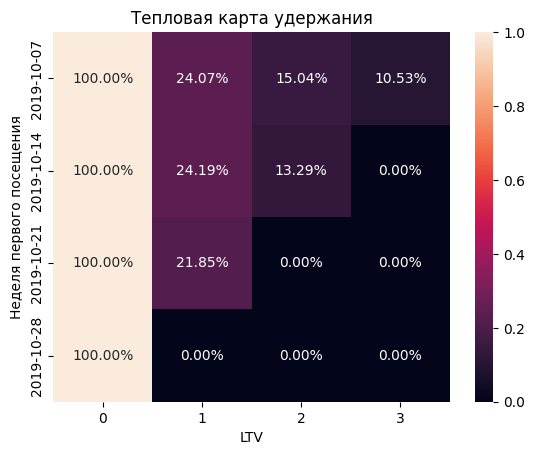

In [23]:
ax = sns.heatmap(
    data2,
    annot=True,
    fmt='.2%', # переводим значения в проценты
)
plt.title('Тепловая карта удержания')
plt.xlabel('LTV')
plt.ylabel('Неделя первого посещения')
plt.show()

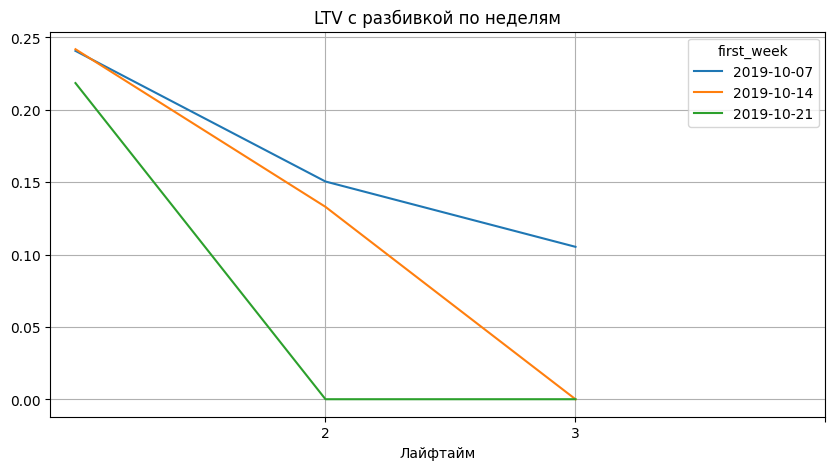

In [24]:
report = data2.drop(columns=[0]).head(3)
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по неделям')
plt.xlabel('Лайфтайм')
plt.show()

**Вывод:** По графику удержания пользователей с разбивкой по неделям видно, что процент удержания пользователей снижается с первой недели (22%) до четвертой недели (11%). Это указывает на то, что удержание пользователей с течением времени ухудшается. Для улучшения показателя удержания пользователей важно постоянно работать над улучшением продукта, вовлеченностью пользователей и созданием положительного пользовательского опыта. Можно использовать A/B-тестирование и другие методы, чтобы определить наиболее эффективные стратегии удержания пользователей и внедрить их.

### Расчет времени одной сессии пользователя

In [25]:
#отсортируем датасет по имени пользователя и дате
data = data.sort_values(['user_id', 'event_time']).reset_index(drop=True)
data.head()

,event_time,event_name,user_id,source,first_dt,event_week,first_week,ltv
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0


In [26]:
#преобразуем данные
data['time'] = pd.to_datetime(data['event_time'])
#установим одну сессию более 20 минут
session = (data.groupby('user_id')['time'].diff() > pd.Timedelta('30Min')).cumsum()
#добавим новый столбец
data['session_id'] = data.groupby(['user_id', session], sort=False).ngroup() + 1
data.head()

,event_time,event_name,user_id,source,first_dt,event_week,first_week,ltv,time,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:39:46,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:40:31,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:41:06,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:43:21,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:45:31,1


Визуализируем распределение количества сессий пользователей

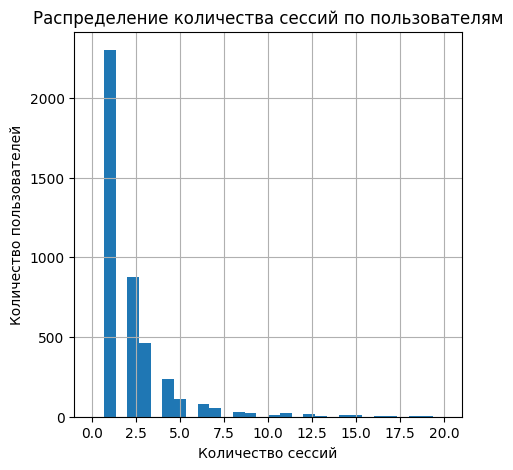

In [27]:
session_distrib = (data.groupby('user_id').agg({'session_id':'nunique'}).sort_values(by = 'session_id', ascending = False).reset_index())
plt.figure(figsize=(5,5))
session_distrib['session_id'].hist(bins=30,range=(0,20))
plt.title('Распределение количества сессий по пользователям')
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.show()

In [28]:
#создадим датафрейм с начальной датой сессии
session_start = data.groupby('session_id').agg({'time' : 'min'}).reset_index().rename(columns={'time' : 'sesion_start'})
#создадим датафрейм с конечной датой сессии
session_end = data.groupby('session_id').agg({'time' : 'max'}).reset_index().rename(columns={'time' : 'sesion_end'})
#объединим полученные датасеты
data5 = session_start.merge(session_end, on = 'session_id')
#находим разницу между началом и окончанием сессии
data5['session_time'] = data5['sesion_end'] - data5['sesion_start']
data5.head()

,session_id,sesion_start,sesion_end,session_time
0,1,2019-10-07 13:39:46,2019-10-07 13:49:42,0 days 00:09:56
1,2,2019-10-09 18:33:56,2019-10-09 18:42:23,0 days 00:08:27
2,3,2019-10-21 19:52:31,2019-10-21 20:07:30,0 days 00:14:59
3,4,2019-10-22 11:18:15,2019-10-22 11:30:53,0 days 00:12:38
4,5,2019-10-19 21:34:34,2019-10-19 21:59:55,0 days 00:25:21


In [29]:
data5.describe()

,session_id,sesion_start,sesion_end,session_time
count,10368.00000,10368,10368,10368
mean,5184.50000,2019-10-22 02:47:00.987171840,2019-10-22 02:59:53.656153600,0 days 00:12:52.668981481
min,1.00000,2019-10-07 00:00:00,2019-10-07 00:05:23,0 days 00:00:00
25%,2592.75000,2019-10-15 20:16:53.500000,2019-10-15 20:34:04.249999872,0 days 00:00:21
50%,5184.50000,2019-10-22 14:53:38.500000,2019-10-22 15:06:33.500000,0 days 00:05:35
75%,7776.25000,2019-10-28 16:14:37.500000,2019-10-28 16:28:44.249999872,0 days 00:17:25.250000
max,10368.00000,2019-11-03 23:56:57,2019-11-03 23:58:13,0 days 05:21:58
std,2993.12813,NaN,NaN,0 days 00:19:51.607952024


**Вывод:** На графике распределения количества сессий пользователя видно, что в среднем на пользователя получатеся 2-3 тридцатиминутные сессии за выбранный период данных. Сессии по 30 минут были выбраны стандартные. Такие используются в я.метрике или google аналитике. В зависимости от степени безопасности приложения: чем меньше время сессии, тем безопаснее. Половина пользователей имела активную сессию чуть больше 5 минут, а максимальная сессия составила больше 5 часов. Думаю, что это не аномалия, а какой-то пользователь вручную просматривал какую-то категорию объявлений и долго выбирал.

### Расчет частоты совершения события. Построение графика

Посмотрим количество всех действий соевершаемых пользователем и построим диграмму

In [30]:
events_repeat = data['event_name'].value_counts()
events_repeat

event_name
tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: count, dtype: int64

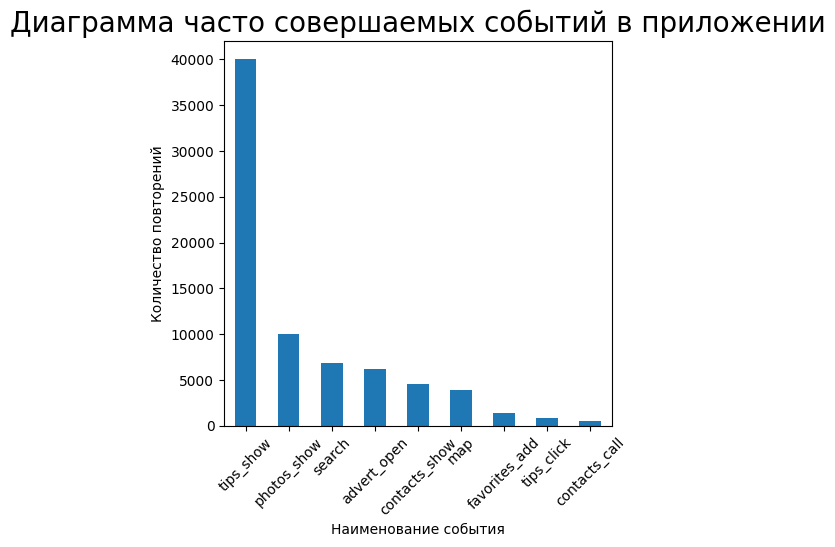

In [31]:
events_repeat.plot(kind = 'bar', figsize = (5, 5))
plt.title('Диаграмма часто совершаемых событий в приложении', fontsize=20)
plt.gca().set(xlabel='Наименование события', ylabel='Количество повторений')
plt.xticks(rotation=45)
plt.show()

**Вывод:** Часто совершаемое действие это просмотр объявлений. Далее в исследовании посмотрим, сколько пользователей дошло до целевого действия - просмотр контактов.

Посчитаем количество действий на каждого пользователя

In [32]:
count_event = data.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()
count_event.head()

,user_id,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


Проверим распределение количества полученных значений

In [33]:
count_event['event_name'].describe()

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: event_name, dtype: float64

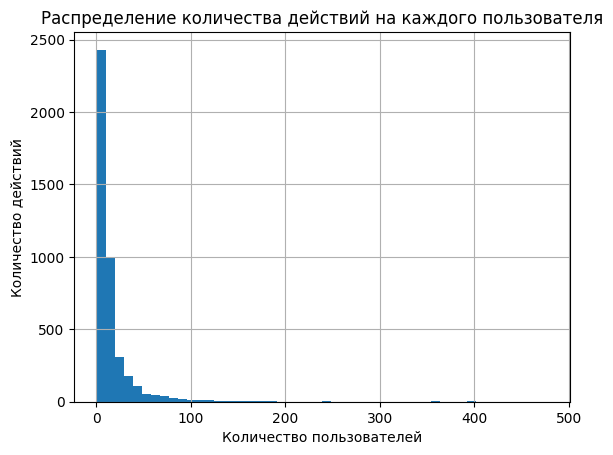

In [34]:
count_event['event_name'].hist(bins=50)
plt.title('Распределение количества действий на каждого пользователя')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество действий')
plt.show()

Минимальное количество действий у пользователя - 1. Вероятно, это просмотр карточки объявления. В среднем каждый пользователь совершал 17 действий. Максимальное значение 478 действий является скорее всего аномальным, чем реальным(возможно у пользователя на клавиатуре запала кнопка ф5 для обновления страницы или на нее сел кот).

### Расчет конверсии пользователей
Конверсия пользователей - это процент пользователей, которые выполняют целевое действие на нашем сайте или приложении (например, покупку товара, заполнение формы, подписку на рассылку и т.д.). В нашем случа это будет "просмотр контакта"

In [35]:
uniq_users = data['user_id'].nunique() #найдем уникальных пользоваетелей
uniq_cr_users = data.loc[data['event_name'] == 'contacts_show']['user_id'].nunique() #отберем пользователей который выполнили целевое действие
convertion_rate = round((uniq_cr_users / uniq_users) *100, 2) #делим количество пользователей выполнивших целевое действие на общее количество
print('Конверсия относительно совершения целевого действия составляет:', convertion_rate, '%')

Конверсия относительно совершения целевого действия составляет: 22.85 %


**Общий вывод:** В процессе исследования одним из важных показателей был расчет lifetime пользователей который показал, что к концу периода количество вернувшихся пользователей упало до 11%. Также, мы рассчитали сессии пользователей и определили, что на одного пользователя приходятся 2-3 тридцатиминутные сессии за выбранный период данных. Самое часто совершаемое событие в приложении является просмотр объявления и менее совершаемое событие это звонок по объявлению. Также, была рассчитана конверсия пользователей которые совершают целевое действие - просмотр контакта. Конверсия составил 22,85%.


## Сегментация пользователей по типу источника привлечения

Разделим по группам пользователей пришедших в приложение из yandex, google и других источников. Такая сегментация позволит понять имеет ли какую-то эффективность различные источники привлечения. Если имеют, то это позволит нам сосредоточить свои усилия на наиболее эффективных. Также, разные источники привлечения могут привлекать разные группы пользователей с разными потребностями и предпочтениями. Например, пользователи, пришедшие из социальных сетей, могут быть более молодыми и активными в социальных медиа, в то время как пользователи, пришедшие из поисковых систем, могут быть более заинтересованы в конкретных продуктах или услугах. Исследование позволяет определить эти различия и настроить маркетинговые стратегии для каждой группы пользователей. В целом, исследование и сегментация пользователей по типу источника привлечения позволяет более эффективно использовать ресурсы и разрабатывать персонализированные маркетинговые стратегии, что в конечном итоге приводит к увеличению прибыли и удовлетворенности клиентов.

In [36]:
user_yandex = data[data['source'] == 'yandex']
user_yandex.head()

,event_time,event_name,user_id,source,first_dt,event_week,first_week,ltv,time,session_id
35,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:34,2019-10-14,2019-10-14,0,2019-10-19 21:34:34,5
36,2019-10-19 21:35:19,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:34,2019-10-14,2019-10-14,0,2019-10-19 21:35:19,5
37,2019-10-19 21:36:44,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:34,2019-10-14,2019-10-14,0,2019-10-19 21:36:44,5
38,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:34,2019-10-14,2019-10-14,0,2019-10-19 21:40:39,5
39,2019-10-19 21:42:14,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:34,2019-10-14,2019-10-14,0,2019-10-19 21:42:14,5


In [37]:
user_google = data[data['source'] == 'google']
user_google.head()

,event_time,event_name,user_id,source,first_dt,event_week,first_week,ltv,time,session_id
116,2019-10-18 22:14:06,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:06,2019-10-14,2019-10-14,0,2019-10-18 22:14:06,12
117,2019-10-18 22:14:17,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:06,2019-10-14,2019-10-14,0,2019-10-18 22:14:17,12
118,2019-10-18 22:17:41,map,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:06,2019-10-14,2019-10-14,0,2019-10-18 22:17:41,12
119,2019-10-20 17:47:19,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:06,2019-10-14,2019-10-14,0,2019-10-20 17:47:19,13
120,2019-10-20 17:47:20,search,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:06,2019-10-14,2019-10-14,0,2019-10-20 17:47:20,13


In [38]:
user_other = data[data['source'] == 'other']
user_other.head()

,event_time,event_name,user_id,source,first_dt,event_week,first_week,ltv,time,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:39:46,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:40:31,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:41:06,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:43:21,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:46,2019-10-07,2019-10-07,0,2019-10-07 13:45:31,1


Рассчитаем Retention rate для группы пользователей пришедших из Yandex, используя тот же расчет, что и выше

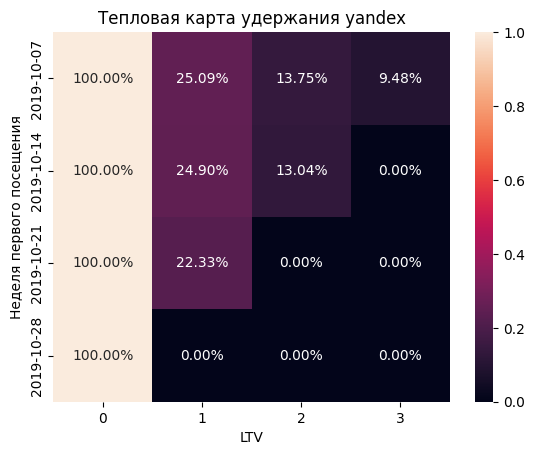

In [39]:
user_yandex['ltv_yandex'] = ((user_yandex['event_week'] - user_yandex['first_week']) / np.timedelta64(1,'W')).astype(int) #рассчет ltv
result_raw_yandex = user_yandex.pivot_table(index=['first_week'], columns='ltv_yandex', values='user_id', aggfunc='nunique')
cohort_sizes_yandex = (
    user_yandex.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
data3 = cohort_sizes_yandex.merge(result_raw_yandex, on='first_week', how='left').fillna(0)
data3 = data3.div(data3['cohort_size'], axis=0).drop(columns=['cohort_size'])
ax = sns.heatmap(
    data3,
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания yandex')  # название графика
plt.xlabel('LTV')
plt.ylabel('Неделя первого посещения')
plt.show()

**Вывод:** количество удержанных пользователей снизилось с первой до третьей недели с 22% до 10% которые пришли из google

Рассчитаем конверсию для пользователей из Yandex

In [40]:
uniq_users_yandex = user_yandex['user_id'].nunique() #найдем уникальных пользоваетелей
uniq_cr_yandex = user_yandex.loc[user_yandex['event_name'] == 'contacts_show']['user_id'].nunique() #отберем пользователей который выполнили целевое действие
convertion_rate = round((uniq_cr_yandex / uniq_users_yandex) *100, 2) #делим количество пользователей выполнивших целевое действие на общее количество
print('Конверсия у пользователей yandex отностительно совершения целевого действия составляет:', convertion_rate, '%')

Конверсия у пользователей yandex отностительно совершения целевого действия составляет: 24.72 %


Рассчитаем Retention rate для группы пользователей пришедших из Google

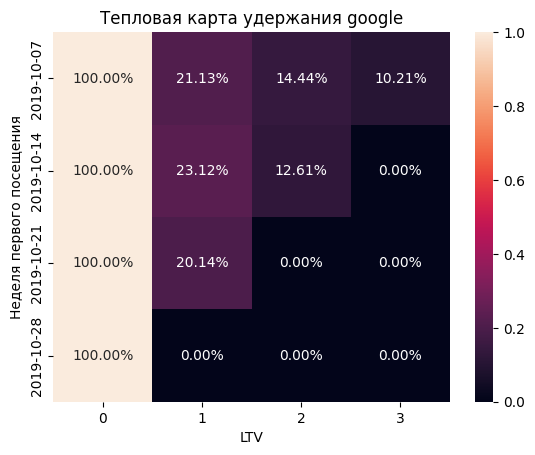

In [41]:
user_google['ltv_google'] = ((user_google['event_week'] - user_google['first_week']) / np.timedelta64(1,'W')).astype(int) #рассчет ltv
result_raw_google = user_google.pivot_table(index=['first_week'], columns='ltv_google', values='user_id', aggfunc='nunique')
cohort_sizes_google = (
    user_google.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
data4 = cohort_sizes_google.merge(result_raw_google, on='first_week', how='left').fillna(0)
data4 = data4.div(data4['cohort_size'], axis=0).drop(columns=['cohort_size'])
ax = sns.heatmap(
    data4,
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания google')  # название графика
plt.xlabel('LTV')
plt.ylabel('Неделя первого посещения')
plt.show()

In [42]:
uniq_users_google = user_google['user_id'].nunique() #найдем уникальных пользоваетелей
uniq_cr_google = user_google.loc[user_google['event_name'] == 'contacts_show']['user_id'].nunique() #отберем пользователей который выполнили целевое действие
convertion_rate = round((uniq_cr_google / uniq_users_google) *100, 2) #делим количество пользователей выполнивших целевое действие на общее количество
print('Конверсия у пользователей google отностительно совершения целевого действия составляет:', convertion_rate, '%')

Конверсия у пользователей google отностительно совершения целевого действия составляет: 24.36 %


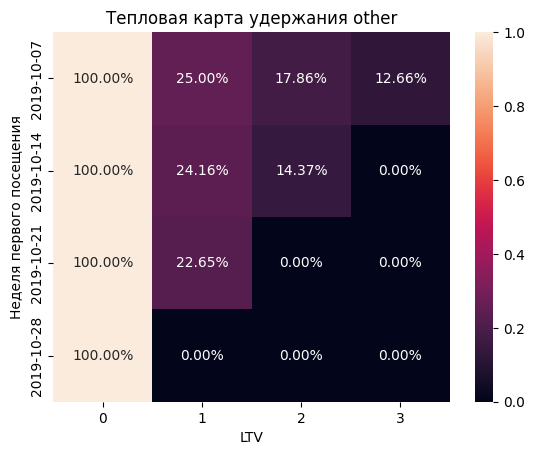

In [43]:
user_other['ltv_other'] = ((user_other['event_week'] - user_other['first_week']) / np.timedelta64(1,'W')).astype(int) #рассчет ltv
result_raw_other = user_other.pivot_table(index=['first_week'], columns='ltv_other', values='user_id', aggfunc='nunique')
cohort_sizes_other = (
    user_other.groupby('first_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
data6 = cohort_sizes_other.merge(result_raw_other, on='first_week', how='left').fillna(0)
data6 = data6.div(data6['cohort_size'], axis=0).drop(columns=['cohort_size'])
ax = sns.heatmap(
    data6,
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания other')  # название графика
plt.xlabel('LTV')
plt.ylabel('Неделя первого посещения')
plt.show()

Рассчитаем конверсию для пользователей из других браузеров

In [44]:
uniq_users_other = user_other['user_id'].nunique() #найдем уникальных пользоваетелей
uniq_cr_other = user_other.loc[user_other['event_name'] == 'contacts_show']['user_id'].nunique() #отберем пользователей который выполнили целевое действие
convertion_rate = round((uniq_cr_other / uniq_users_other) *100, 2) #делим количество пользователей выполнивших целевое действие на общее количество
print('Конверсия у пользователей google отностительно совершения целевого действия составляет:', convertion_rate, '%')

Конверсия у пользователей google отностительно совершения целевого действия составляет: 18.54 %


**Вывод:** Выполнив сегментацию пользователей по типу источника привлечения было установлено, что пользователи пришедшие из yandex имеют бОльшую конверсию(24,36%), чем пользователи пришедшие из google. Но, процент удержания пользователей google к последней неделе наоборот больше, чем у yandex. Для улучшения показателя удержания пользователей из обоих источников можно провести более детальный анализ поведения и предпочтений этих групп пользователей. Это может помочь определить специфические причины, по которым пользователи из каждого источника покидают объявление. Также стоит обратить внимание на эффективность маркетинговых кампаний в каждом из источников. Возможно, необходимо пересмотреть стратегию привлечения пользователей из Yandex или Google, чтобы привлекать более лояльную аудиторию или повысить конверсию.

## Определение статистических гипотез и их проверка

### Формулировка гипотезы заказчика
Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

Определим нулевую и альтернативные гипотезы:

* H0: Не существует статистически значимых отличий между пользователями, которые установили приложение по ссылке из Google, и пользователями, которые пришли через ссылку из Yandex.

* H1: Существуют статистически значимые отличия между пользователями, которые установили приложение по ссылке из Google, и пользователями, которые пришли через ссылку из Yandex.

Возьмем датафреймы с уже выделенными данными по группам уникальных пользователей из yqndex и google(uniq_cr_yandex и uniq_cr_google), а также рассчитанные по ним конверсии в целевое действие. Создадим массив с использоваением этих таблиц

In [45]:
#создадим массивы данных из таблиц уникальных пользователей и уникальных пользователей совершивших целевое действие для проведения z-теста
purchases = np.array([uniq_cr_google, uniq_cr_yandex])
leads = np.array([uniq_users_google, uniq_users_yandex])

In [46]:
alpha = 0.05 # критический уровень статистической значимости

# пропорция успехов в первой группе:
p1 = purchases[0] / leads[0]
# пропорция успехов во второй группе:
p2 = purchases[1] / leads[1]

# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
# разница пропорций в датасетах
difference = p1-p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0,1)

#удвоим результат так как тест двусторонний
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: статистически значимые отличия между пользователями есть')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: статистически значимых отличий между пользователями нет'
    )

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу: статистически значимых отличий между пользователями нет


**Вывод:** исходя из расчетов, видим, что нет оснований отвергать нулевую гипотезу. Статистически значимых различий между долями конверсии в целевое событие пользователей из различных источников нет.

### Формулировка собственной гипотезы 
Существует разница в среднем времени, проведенном в приложении между группами пользователей, которые совершили целевое действие (пользователь позвонил по номеру телефона), и теми, кто этого не сделал.

Определим нулевую и альтернативные гипотезы:

* H0: Не существует статистически значимых отличий в конверсии по целевому действию между уникальными пользователями группы с короткими сессиями и уникальными пользователями с длинными сессиями

* H1: Существуют статистически значимых отличий в конверсии по целевому действию между уникальными пользователями группы с короткими сессиями и уникальными пользователями с длинными сессиями

In [47]:
#переименуем колонки в датасете который содержит распределение количества сессий пользователей
session_distrib.columns = ['user_id', 'session_id_new']
# объеденим датасет распределния количества сессий с исходным датасетом
data = data.merge(session_distrib, on = 'user_id', how = 'left')
# определим наши группы
test_A = data[data['session_id_new'] == 1]
test_B = data[data['session_id_new'] == 2]
# найдем общее количество уникальных пользователей в 1й группе
test_A_total = test_A['user_id'].nunique()
# найдем количество уникальных пользователей совершихших целевое действие в 1й группе
test_A_cr = test_A.loc[test_A['event_name'] == 'contacts_call']['user_id'].nunique()

print('Конверсия 1й группы составляет -', round((test_A_cr / test_A_total) * 100, 2), '%')

# находим общее количество уникальных пользователей в 2й группе
test_B_total = test_B['user_id'].nunique()
# находим количество уникальных пользователей совершихших целевое действие в 2й группе
test_B_cr = test_B.loc[test_B['event_name'] == 'contacts_call']['user_id'].nunique()

print('Конверсия 2й группы составляет -', round((test_B_cr / test_B_total) * 100, 2), '%')
#создаем массивы с данными для проведения z-теста
purchases = np.array([test_A_cr, test_B_cr])
leads = np.array([test_A_total, test_B_total])

Конверсия 1й группы составляет - 1.83 %
Конверсия 2й группы составляет - 5.58 %


In [48]:
alpha = 0.05 # критический уровень статистической значимости

# пропорция успехов в первой группе:
p1 = purchases[0] / leads[0]
# пропорция успехов во второй группе:
p2 = purchases[1] / leads[1]

# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
# разница пропорций в датасетах
difference = p1-p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0,1)

#удвоим результат так как тест двусторонний
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: статистически значимые отличия между пользователями есть')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: статистически значимых отличий между пользователями нет'
    )

p-значение:  1.3850260716097296e-08
Отвергаем нулевую гипотезу: статистически значимые отличия между пользователями есть


**Вывод:** Составив собственную гипотезу видим ту же историю, что и в гипотезе заказчика. Нет оснований отвергать нулевую гипотезу. Статистически значимых различий между долями конверсии в целевое событие пользователей с короткими или длинными сессиями нет.

## Презентация

Презентация подготовлена по ссылке: https://disk.yandex.ru/i/_8c8GOCovbvzvg

## Дашборд

Дашборд подготовлен по ссылке: https://public.tableau.com/views/20_MobileAppNenuzhnievechiSalnevM/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Общий вывод
В ходе работы была выполнена предобработка данных которая позволила использовать данные для дальнейшего анализа и принятия решения. Дальнейшее исследование позволило нам получить представление о поведении пользователей в приложении и оценить его эффективность. После расчета Retention rate было установлено, что с каждой неделей процент удежрания пользователей становился меньше. С чем это связано точно ответить нельзя. Далее, было определено время одно сессии пользователя. В среднем на одного пользователя получается 2-3 тридцатиминутные сесии. Самое часто совершаемое действие - просмотр карточки объявления. В среднем, каждый пользователь совершал 17 действий. Также, была рассчитана конверсия пользователей в целевое событие - просмотр контака. Конверсия составила 23%. Сегментировав пользователей по типу источника привлечения, было установлено, что из поиска google бОльшее число пользователей доходит по целевого действия.
Сформулированные гипотезы были отвергнуты в ходе исследования
* Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.
* Существует разница в среднем времени, проведенном в приложении между группами пользователей, которые совершили целевое действие (пользователь позвонил по номеру телефона), и теми, кто этого не сделал.

Эти результаты указывают на то, что источник привлечения и время проведенное в приложении не являются значимыми факторами, влияющими на конверсию в просмотры контактов. 

Рекомендации по развитию приложения:
Для улучшения возвращаемости пользователей можно попробовать рассылку в почте или рассылку в самом приложении. Важно выбрать корректный период использования, так как слишком частые рассылки заставят пользователя скорее отключить ее или совсем удалить приложение. Тогда пользователя потеряем совсем. Также, можно переработать интерфейс и добавить новую фичу. Например, сейчас, не малоизвестный сайт по продаже автомобилей предлагает за звонок по объявлению бесплатный отчет по нему. Таким образом, выполнение целевого действия повышается.